<a href="https://colab.research.google.com/github/FanchonSora/AI-Project-Course/blob/main/Medical_prescription_to_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Cài đặt các thư viện cần thiết và Tesseract OCR
!sudo apt-get install tesseract-ocr -qq
!pip install opencv-python Pillow pytesseract pandas -qq

In [ ]:
# 2. Mount Google Drive chứa dữ liệu
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#3. Import các thư viện
import cv2
import pytesseract
import os
import pandas as pd
from PIL import Image
from transformers import pipeline
import re

In [ ]:
# 4. Định nghĩa đường dẫn tới các thư mục và file dữ liệu
# Thư mục chứa ảnh đơn thuốc
prescription_images_folder = '/content/drive/MyDrive/AI_Project/dataset/prescription_images'
# Thư mục lưu các file OCR text tương ứng với ảnh đơn thuốc
prescription_texts_folder = '/content/drive/MyDrive/AI_Project/dataset/prescription_texts'
# File CSV chứa metadata của DrugBank (giả sử file có cột: drug_id, drug_name, description, [drug_image_path])
drugbank_metadata_path = '/content/drive/MyDrive/AI_Project/dataset/drugbank_metadata.csv'
# Định nghĩa đường dẫn tới thư mục chứa ảnh của thuốc (drug_images)
drug_images_folder = '/content/drive/MyDrive/AI_Project/dataset/drug_images'

In [ ]:
# 5. Load dữ liệu metadata của DrugBank
if not os.path.exists(drugbank_metadata_path):
    print("Không tìm thấy file drugbank_metadata.csv tại đường dẫn:", drugbank_metadata_path)
else:
    drugbank_df = pd.read_csv(drugbank_metadata_path, encoding='cp1252')
    print("Đã load metadata của DrugBank với", len(drugbank_df), "dòng dữ liệu.")

Đã load metadata của DrugBank với 12 dòng dữ liệu.


In [ ]:
# 6. Hàm OCR: Chuyển ảnh thành text sử dụng pytesseract
def ocr_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Không đọc được ảnh:", image_path)
        return ""
    # Chuyển ảnh sang grayscale để cải thiện OCR
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # (Tùy chọn) Bạn có thể áp dụng threshold, blur,... nếu cần
    text = pytesseract.image_to_string(gray, lang='eng')  # Nếu đơn thuốc là tiếng Việt, thay 'eng' bằng 'vie'
    return text

In [ ]:
# 7. Hàm so khớp (match) tên thuốc trong OCR text với metadata DrugBank
# Phương pháp đơn giản: chuyển text và tên thuốc về chữ thường và tìm xem tên thuốc có xuất hiện trong text hay không.
def extract_drug_info(ocr_text, drugbank_df):
    found_drugs = []  # Danh sách chứa các dòng metadata của DrugBank khớp
    text_lower = ocr_text.lower()
    for idx, row in drugbank_df.iterrows():
        drug_name = str(row['drug_name']).lower().strip()
        if drug_name in text_lower:
            found_drugs.append(row)
    return found_drugs


In [ ]:
# 8. Hàm trích xuất các candidate tên thuốc từ OCR text (theo giả định mỗi dòng ngắn, chứa chữ cái)
def extract_candidate_drug_names(ocr_text):
    candidates = []
    for line in ocr_text.splitlines():
        line = line.strip()
        # Giả sử nếu dòng có từ 2 đến 50 ký tự và chứa chữ cái, ta xem đó là candidate tên thuốc
        if 2 <= len(line) <= 50 and re.search(r'[A-Za-z]', line):
            candidates.append(line)
    return candidates

------------------------------------------------------
Đang xử lý ảnh: 24.jpg
Không tìm thấy thuốc nào khớp với nội dung OCR.
Không tìm thấy thuốc: Dr, Raja Nag
Không tìm thấy thuốc: MBBS, MD. DNS
Không tìm thấy thuốc: (Cardio ;
Không tìm thấy thuốc: Sere ie Cemesitaes lotogy)
Không tìm thấy thuốc: i ae a
Không tìm thấy thuốc: rt co A we | vg Se o a ‘y
Không tìm thấy thuốc: (aD a Ve :
Không tìm thấy thuốc: oat ; j
Không tìm thấy thuốc: ‘ a
Không tìm thấy thuốc: a - — - - i 2 —_—
Không tìm thấy thuốc: (a te 2 ats Laas: ; v
Không tìm thấy thuốc: \—-/ ; s\ of Ay Pnn } c
------------------------------------------------------

------------------------------------------------------
Đang xử lý ảnh: 73.jpg
Không tìm thấy thuốc nào khớp với nội dung OCR.
Không tìm thấy thuốc: Ma ali i
Không tìm thấy thuốc: | Allergies; LINo Known allergies
Không tìm thấy thuốc: Temperature
Không tìm thấy thuốc: Pulse [ Olfany
Không tìm thấy thuốc: Head Circumference (<2 Yr)
Không tìm thấy thuốc: Weight te ky K 

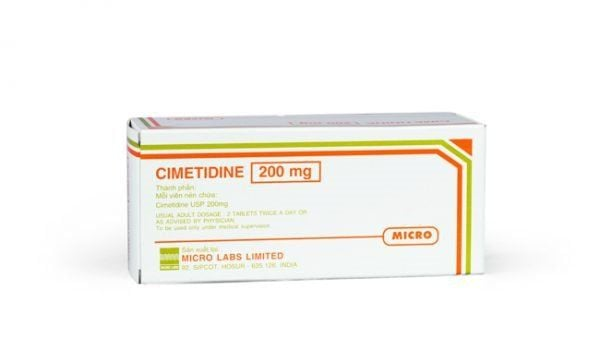

----------------------------------
Tên thuốc: Betaloe
Mã thuốc: DB007
Ảnh của thuốc:


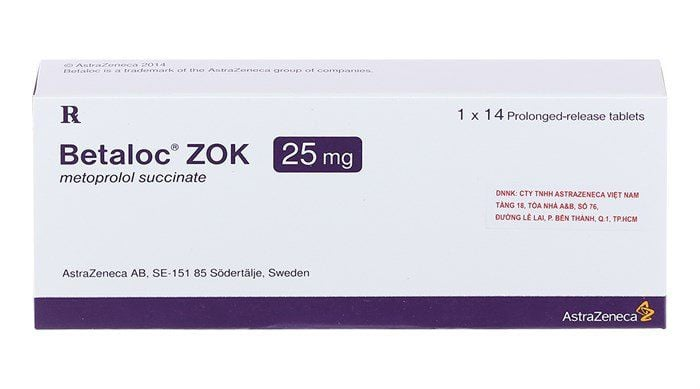

----------------------------------
Không tìm thấy thuốc: RIVERSIDE MEDICAL CENTRE
Không tìm thấy thuốc: 824 14" Street
Không tìm thấy thuốc: New York, NY 91743, USA
Không tìm thấy thuốc: name_ Joba Smith, ace 34
Không tìm thấy thuốc: appress_/6Z Example St V7 pare O9-l/-1Z
Không tìm thấy thuốc: Betaloe 100ms - 1 tab BID
Không tìm thấy thuốc: Doreclamidvn IO mg = | te BID
Không tìm thấy thuốc: Cimetidine SO mg 2 tabs TID
Không tìm thấy thuốc: Orprelal SOmg - | teb GD
Không tìm thấy thuốc: De. Steve Jolson
Không tìm thấy thuốc: Signature
Không tìm thấy thuốc: CLABEL _
Không tìm thấy thuốc: REFILL O(D2 3 4 5 PRN
------------------------------------------------------

------------------------------------------------------
Đang xử lý ảnh: 98.jpg
Không tìm thấy thuốc nào khớp với nội dung OCR.
Không tìm thấy thuốc: H —(G[U [20274
Không tìm thấy thuốc: GE RAMAIAH __| PATIENT = in 4
Không tìm thấy thuốc: Memorial Hospital | PRESCRIPTION ‘aul ufrou
Không tìm thấy thuốc: CGwHN—- 262
Không tìm th

AttributeError: 'float' object has no attribute 'lower'

In [ ]:
# 9. Xử lý từng ảnh đơn thuốc:
# - Chạy OCR và lưu text vào folder prescription_texts
# - So khớp với DrugBank metadata để trích xuất thông tin thuốc
# - Hiển thị ảnh đơn thuốc, nội dung OCR và thông tin của các thuốc được tìm thấy.
for filename in os.listdir(prescription_images_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(prescription_images_folder, filename)
        print("------------------------------------------------------")
        print("Đang xử lý ảnh:", filename)

        # 8.1. Chạy OCR trên ảnh đơn thuốc
        ocr_text = ocr_image(image_path)

        # 8.2. Lưu OCR text vào file tương ứng (lưu với encoding cp1252 theo yêu cầu)
        text_filename = os.path.splitext(filename)[0] + '.txt'
        text_filepath = os.path.join(prescription_texts_folder, text_filename)
        with open(text_filepath, 'w', encoding='utf-8') as f:
            f.write(ocr_text)

        # 8.3. So khớp tên thuốc từ OCR với metadata DrugBank
        matched_drugs = extract_drug_info(ocr_text, drugbank_df)

        # 8.4. Hiển thị ảnh đơn thuốc
        #print("Ảnh đơn thuốc:")
        #display(Image.open(image_path))

        # 8.5. Hiển thị thông tin các thuốc được tìm thấy
        if matched_drugs:
            print("Thông tin thuốc được trích xuất:")
            # Tạo danh sách tên thuốc đã tìm thấy (so sánh theo chữ thường)
            found_names = [drug['drug_name'].lower() for drug in matched_drugs]
            for drug in matched_drugs:
                print("Tên thuốc:", drug['drug_name'])
                print("Mã thuốc:", drug['drug_id'])
                # Nếu có đường dẫn ảnh của thuốc
                if 'drug_image_path' in drug and pd.notna(drug['drug_image_path']):
                    drug_img_value = str(drug['drug_image_path']).lstrip("/")  # loại bỏ "/" đầu nếu có
                    drug_img_path = os.path.join(drug_images_folder, drug_img_value)
                    if os.path.exists(drug_img_path):
                        print("Ảnh của thuốc:")
                        display(Image.open(drug_img_path))
                    else:
                        print("Không tìm thấy ảnh của thuốc tại:", drug_img_path)
                print("----------------------------------")
            # Kiểm tra các candidate tên thuốc từ OCR mà không khớp với metadata
            candidate_drugs = extract_candidate_drug_names(ocr_text)
            for candidate in candidate_drugs:
                if candidate.lower() not in found_names:
                    print("Không tìm thấy thuốc:", candidate)
        else:
            # Nếu không có drug nào khớp, in ra các candidate từ OCR
            print("Không tìm thấy thuốc nào khớp với nội dung OCR.")
            candidate_drugs = extract_candidate_drug_names(ocr_text)
            for candidate in candidate_drugs:
                print("Không tìm thấy thuốc:", candidate)
        print("------------------------------------------------------\n")

# Mục mới